#### If using AMD GPU, switch backend to PlaidML library:

In [1]:
import os
os.environ['KERAS_BACKEND']='plaidml.keras.backend'

In [1]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.utils import Sequence
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from keras_preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import time
import pickle
from keras.models import load_model
import pandas as pd

Using TensorFlow backend.


#### Define Experiment Hyperparameters

In [2]:
conv_layers = [5]      # number of conv layers
layer_sizes = [32]     # number of nodes in a layer
dense_layers = [2]     # number of dense layers

#### Load input data

In [3]:
pickle_in = open('../Dataset/df_all.pickle', 'rb')
df_train, df_test = pickle.load(pickle_in)

In [4]:
# The Keras ImageDataGenerator uses string type data label
df_train['gender'] = df_train.gender.astype(str)
df_test['gender'] = df_test.gender.astype(str)

In [5]:
print(df_train.shape, df_test.shape)

(196464, 10) (10340, 10)


In [6]:
df_train.dtypes

path                object
id                  uint16
name                object
dob         datetime64[ns]
gender              object
score1             float64
score2             float64
pic_date    datetime64[ns]
region              object
age                float64
dtype: object

We will be using a generator to feed model with images, the X would be the path to these images. y will be the gender label.

In [7]:
image_reshape_size = 100
input_image_root_dir = '../Dataset/imdb_crop/' # Don't forget the ending slash

In [8]:
from keras import backend as K
K.set_image_data_format('channels_last')
batch_size = 64
inputShape = (image_reshape_size, image_reshape_size, 1)

In [30]:
df_train.head(3)

,path,id,name,dob,gender,score1,score2,pic_date,region,age
162143,58/nm0005158_rm1436916480_1970-11-20_2003.jpg,16965,Sabrina Lloyd,1970-11-20,0,4.224586,NaN,2003-01-01,"[107.93942350923744, 54.230711754618724, 187.9...",32.115649
129828,07/nm0001807_rm1897044736_1933-12-19_2007.jpg,3752,Cicely Tyson,1933-12-19,0,3.434887,NaN,2007-01-01,"[78.75376318187809, 59.19832238640856, 166.221...",73.036407
389973,79/nm0272479_rm1974701056_1975-10-22_2009.jpg,9031,Jesse Tyler Ferguson,1975-10-22,1,0.899851,NaN,2009-01-01,"[205.814, 123.83, 266.448, 184.464]",33.197122


#### Set up input image generator using flow_from_dataframe

In [10]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

# train_generator = datagen.flow_from_dataframe(dataframe=df_train,
#                                             directory=input_image_root_dir,
#                                             x_col="path", y_col="gender",
#                                             subset="training",
#                                             class_mode="binary",
#                                             color_mode="grayscale",
#                                             target_size=(image_reshape_size,image_reshape_size),
#                                             batch_size=batch_size,
#                                             seed=1,
#                                             shuffle=True)

# val_generator = datagen.flow_from_dataframe(dataframe=df_train,
#                                             directory=input_image_root_dir,
#                                             x_col="path", y_col="gender",
#                                             subset="validation",
#                                             class_mode="binary",
#                                             color_mode="grayscale",
#                                             target_size=(image_reshape_size,image_reshape_size),
#                                             batch_size=batch_size,
#                                             seed=1,
#                                             shuffle=True)

test_generator = datagen.flow_from_dataframe(dataframe=df_test, 
                                            directory=input_image_root_dir, 
                                            x_col="path", y_col=None, 
                                            class_mode=None, 
                                            color_mode="grayscale",
                                            target_size=(image_reshape_size,image_reshape_size),
                                            batch_size=1,
                                            shuffle=False)

Found 10340 validated image filenames.


#### Training trials

In [ ]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            
            NAME = 'BN-{}-conv-{}-node-{}-dens-{}'.format(conv_layer, layer_size, dense_layer, int(time.time()))  # model name with timestamp
            print(NAME) 
            
            # Make sure the following subfolder exist
            tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
            checkpoint = ModelCheckpoint('weights/{}'.format(NAME), monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
            callbacks = [tensorboard, checkpoint]
            
            model = Sequential()
            
            # first layer
            model.add(Conv2D(layer_size, (3,3), padding="same", activation="relu", input_shape=inputShape))
            model.add(BatchNormalization())
            model.add(MaxPooling2D(pool_size=(3,3)))
            
            # sets up additional # of conv layers
            for _ in range(conv_layer - 1):
                layer_size *= 2
                model.add(Conv2D(layer_size, (3,3), padding="same", activation="relu"))
                model.add(BatchNormalization())
                model.add(Conv2D(layer_size, (3,3), padding="same", activation="relu"))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(pool_size=(2,2)))
                model.add(Dropout(0.35))   # Started with 0.25, increased to 0.5
            
            model.add(Flatten())
            
            layer_size *= 4 # to get the dense layer to be 8X of last output size
            
            # sets up # of dense layers
            for _ in range(dense_layer):
                model.add(Dense(layer_size, activation='relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.6))    # started with 0.5, increased to 0.7
            
            # output layer
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            
            # Optional for resuming, load weights
            model.load_weights('weights/BN-5-conv-32-node-2-dens-1554706050')

            opt = Adam(lr=0.0005)   # Start with default of 0.001, slow down in subsequent epoch manually if needed
            model.compile(loss='binary_crossentropy', 
                          optimizer=opt,
                          metrics=['accuracy'])
            
#             model.fit_generator(generator=train_generator,
#                                 steps_per_epoch=(train_generator.n // train_generator.batch_size),
#                                 callbacks = callbacks,
#                                 validation_data=val_generator,
#                                 validation_steps=(val_generator.n // val_generator.batch_size),
#                                 epochs=15,
#                                 use_multiprocessing=False,
#                                 workers=4)


#### Save model

In [58]:
# model.save('my_model.h5')

#### Evaluation

In [11]:
model = load_model('CNN-final-model-v2.h5')

In [12]:
from sklearn.metrics import confusion_matrix
test_generator.reset()
pred=model.predict_generator(test_generator,
                            steps=test_generator.n//test_generator.batch_size,
                            verbose=1)


10340/10340 [==============================] - 236s 23ms/step


In [13]:
y_true = df_test.gender.astype(int)
y_pred = [1 if x>=0.5 else 0 for x in pred]
cm = confusion_matrix(y_true, y_pred)

In [14]:
cm

array([[3690, 1435],
       [ 586, 4629]])

In [15]:
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

Specificity

In [16]:
TN/(TN+FP)

0.72

Precision

In [17]:
TP/(TP+FP)

0.7633575197889182

Recall

In [28]:
TP/(TP+FN)

0.8876318312559923

Accuracy

In [19]:
(TP+TN)/(TN+TP+FN+FP)

0.8045454545454546

In [21]:
from matplotlib import pyplot
import seaborn as sn

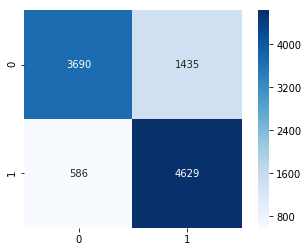

In [27]:
sn.heatmap(cm, annot=True, square=True, cmap='Blues',  fmt='g')